In [1]:
import numpy as np

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, optimizers, callbacks, losses
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

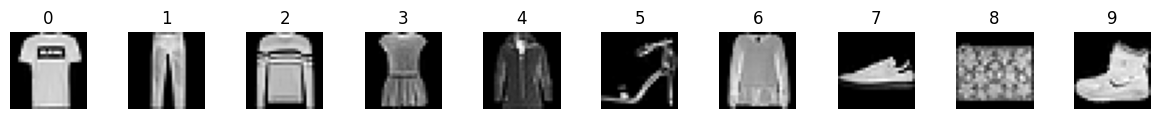

In [3]:
# Define the labels
labels = np.arange(10)

# Plot a sample image from each label
fig, axs = plt.subplots(1, 10, figsize=(15, 1))
for i, label in enumerate(labels):
    ax = axs[i]
    img = x_train[y_train == label][0]
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    ax.set_title(str(label))
plt.show()

In [4]:
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add a channel dimension to the images
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Convert labels to categorical one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [6]:
# Define the data augmentation pipeline
datagen = image.ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

In [7]:
# Define the CNN model architecture
model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    layers.ReLU(),
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=(3, 3)),
    layers.ReLU(),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same'),
    layers.ReLU(),
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=(3, 3)),
    layers.ReLU(),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
    layers.ReLU(),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3, 3)),
    layers.ReLU(),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1024),
    layers.ReLU(),
    layers.Dropout(0.5),
    layers.Dense(512),
    layers.ReLU(),
    layers.Dense(10)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 re_lu (ReLU)                (None, 28, 28, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        36928     
                                                                 
 re_lu_1 (ReLU)              (None, 26, 26, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 64)       256       
 hNormalization)                                        

In [8]:
# Compile the model
model.compile(loss=losses.CategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

In [9]:
# Define early stopping and checkpoint callbacks
early_stopping_cb = callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=True)
checkpoint_cb = callbacks.ModelCheckpoint("fashion_mnist_cnn_model.h5", save_best_only=True, verbose=True)

In [10]:
# Train the model with data augmentation
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=256),
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping_cb, checkpoint_cb]
)

Epoch 1/100
211/211 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.7261
Epoch 1: val_loss improved from inf to 3.10792, saving model to fashion_mnist_cnn_model.h5
211/211 [==============================] - 20s 77ms/step - loss: 0.7422 - accuracy: 0.7261 - val_loss: 3.1079 - val_accuracy: 0.1432
Epoch 2/100
211/211 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.8278
Epoch 2: val_loss improved from 3.10792 to 1.07251, saving model to fashion_mnist_cnn_model.h5
211/211 [==============================] - 14s 68ms/step - loss: 0.4640 - accuracy: 0.8278 - val_loss: 1.0725 - val_accuracy: 0.5975
Epoch 3/100
211/211 [==============================] - ETA: 0s - loss: 0.3851 - accuracy: 0.8586
Epoch 3: val_loss improved from 1.07251 to 0.59592, saving model to fashion_mnist_cnn_model.h5
211/211 [==============================] - 14s 68ms/step - loss: 0.3851 - accuracy: 0.8586 - val_loss: 0.5959 - val_accuracy: 0.8115
Epoch 4/100
211/211 [========

211/211 [==============================] - 14s 68ms/step - loss: 0.1831 - accuracy: 0.9321 - val_loss: 0.2328 - val_accuracy: 0.9162
Epoch 28/100
211/211 [==============================] - ETA: 0s - loss: 0.1810 - accuracy: 0.9339
Epoch 28: val_loss did not improve from 0.19433
211/211 [==============================] - 14s 68ms/step - loss: 0.1810 - accuracy: 0.9339 - val_loss: 0.1997 - val_accuracy: 0.9262
Epoch 29/100
211/211 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9370
Epoch 29: val_loss did not improve from 0.19433
211/211 [==============================] - 14s 68ms/step - loss: 0.1758 - accuracy: 0.9370 - val_loss: 0.2161 - val_accuracy: 0.9228
Epoch 30/100
211/211 [==============================] - ETA: 0s - loss: 0.1751 - accuracy: 0.9377
Epoch 30: val_loss did not improve from 0.19433
211/211 [==============================] - 14s 68ms/step - loss: 0.1751 - accuracy: 0.9377 - val_loss: 0.2054 - val_accuracy: 0.9302
Epoch 31/100
211/211 [========

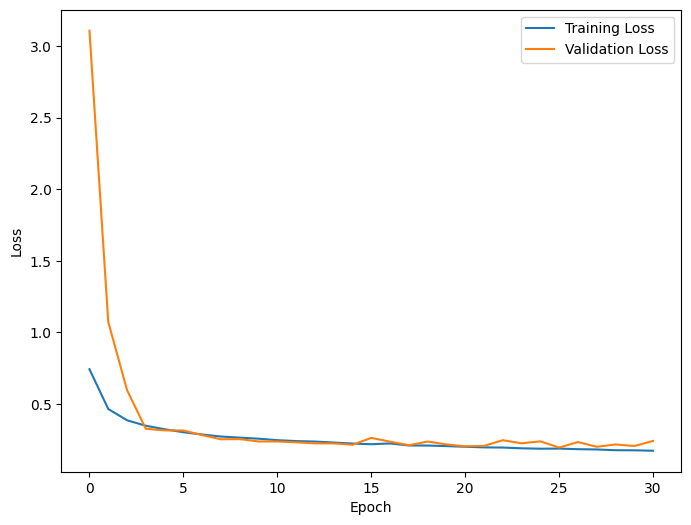

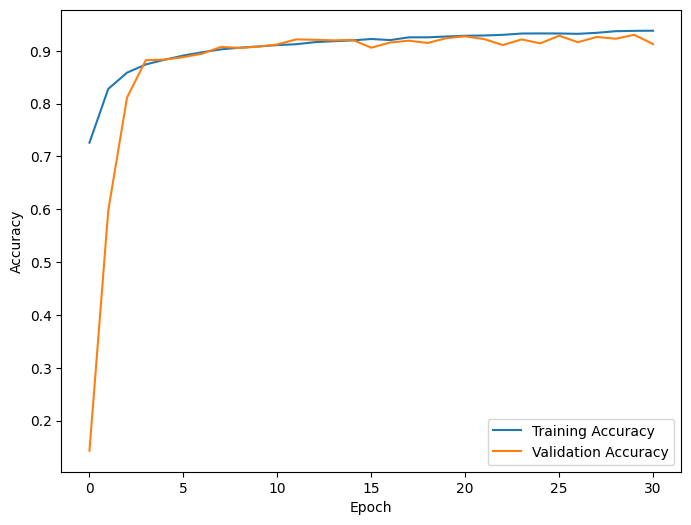

In [11]:
# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [12]:
# Evaluate the model on the test set
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.20480695366859436
Test accuracy: 0.927299976348877


In [13]:
# Evaluate the model on the test set
score = model.evaluate(x_train, y_train, verbose=0)
print("Train loss:", score[0])
print("Train accuracy:", score[1])

Train loss: 0.14440636336803436
Train accuracy: 0.947425901889801


In [14]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add a channel dimension to the images
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Convert labels to categorical one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [15]:
# Evaluate the model on the test set
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.20480695366859436
Test accuracy: 0.927299976348877


In [16]:
# Evaluate the model on the test set
score = model.evaluate(x_train, y_train, verbose=0)
print("Train loss:", score[0])
print("Train accuracy:", score[1])

Train loss: 0.14939917623996735
Train accuracy: 0.9455333352088928
